In [1]:
from keras.layers import Concatenate, Activation, Lambda, Subtract, Dot, Multiply
from keras.layers import Input, Dense, Flatten, Convolution1D, RepeatVector, Add
from keras.engine.topology import Container
from keras.models import Model, Sequential
from keras.initializers import Zeros
from keras.applications.vgg19 import VGG19
from keras.activations import softmax
from keras import backend as K
from keras import optimizers
import sys, glob, math, os
import cv2
import numpy as np
import re
from numpy.random import *
import h5py

ncluster = 50
nfeature = 196
nfeature_dim = 512
nbatch = 2

Using TensorFlow backend.


In [2]:
def custom_softmax(x):
    y = softmax(x, axis=1)
    return y

In [3]:
def transpose(x):
    x = K.permute_dimensions(x,(1,2,0))
    y = K.transpose(x)
    return y

In [4]:
def make_feature_tensor(x,i,c):
    # make [xi-c(1) xi-c(2) ... xi-c(n)] tensor
    t = x[:,i,:]
    z = K.repeat(t, ncluster)
    z = z - c
#    z = K.permute_dimensions(z,(0,1,2))
    return z

In [5]:
def rep_tensor_and_mult(w,x,c,batch_size):
    zz = K.zeros(shape=(batch_size,nfeature_dim,ncluster))
    
    for i in range(0,nfeature):
        # Feature vector
        t = x[:,i,:]
        t = K.repeat(t, ncluster)
        t = t - c
        t = K.permute_dimensions(t,(1,2,0))
        t = K.transpose(t)
        
        # Weight vector
        ww = w[:,i,:]
        z = K.repeat(ww, nfeature_dim)
                
        tmp = z*t
        zz = zz + tmp
        # K.update_add(zz,tmp)
        #zz = zz + tmp
        #zz = K.update_add(zz,tmp)
    
    return zz

In [6]:
def generator_loss(y_true, y_pred): # y_true's shape=(batch_size, row, col, ch)
    S = ncluster*nfeature_dim
    x1 = y_pred[:,:S]
    x2 = y_pred[:,S:]
    z = K.batch_dot(x1,x2,axes=1)
    z = K.abs(y_true - z)
    return z

In [7]:
def L1_normalize(x):
    #x = K.l2_normalize(x, axis=1)
    x = x / K.sum(x, axis=1, keepdims=True)
    return x

In [8]:
def L2_normalize(x):
    x = K.l2_normalize(x, axis=1)
    #x = x / K.sum(x, axis=1, keepdims=True)
    return x

In [9]:
def netvlad_model():
    # input feature and cluster centers
    x_input  = Input([nfeature,nfeature_dim], name='x_input')
    x_input2 = Input([nfeature,nfeature_dim], name='x_input2') 
    c_input = Input([ncluster,nfeature_dim], name='c_input')
    
    # start designing BASE_LAYERS
    conv_1 = []
    for i in range(0,ncluster):
        x = Convolution1D(1, 1, padding='same', use_bias=True, name='conv1d_%d'%i)(x_input)
        conv_1.append(x)
    
    w = Concatenate(axis=2)(conv_1)
    w = Lambda(custom_softmax, name='custom_softmax')(w)
    z = Lambda(rep_tensor_and_mult, arguments={'x': x_input,'c': c_input,'batch_size': nbatch}, name='rep_tensor_mult')(w)
    z = Flatten()(z)
    z = Lambda(L2_normalize)(z)
    # end BASE_LAYERS
    
    # define second reference layers
    base_layers = Container(x_input, z, name="base_layers")
    z2 = base_layers(x_input2)
    
    # concatenate in one list
    z_list = []    
    z_list.append(z)
    z_list.append(z2)
    
    z_out = Concatenate()(z_list)
    #z_out = Lambda(Split_and_dot)(z_out)
    
    model = Model(inputs=[x_input,x_input2,c_input], outputs=z_out)
    
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss=generator_loss)
    
#    model.summary()
 
    return model
#END vgg19_lower_model()

In [10]:
def netvlad_pred_model(model_src):
    # input feature and cluster centers
    x_input  = Input([nfeature,nfeature_dim], name='x_input')
    c_input = Input([ncluster,nfeature_dim], name='c_input')
    
    # start designing BASE_LAYERS
    conv_1 = []
    for i in range(0,ncluster):
        x = model_src.get_layer(name='conv1d_%d'%i)(x_input)
        conv_1.append(x)
    
    w = Concatenate(axis=2)(conv_1)
    w = Lambda(custom_softmax, name='custom_softmax')(w)
    z = Lambda(rep_tensor_and_mult, arguments={'x': x_input,'c': c_input,'batch_size': nbatch}, name='rep_tensor_mult')(w)
    z = Flatten()(z)
    z = Lambda(L2_normalize)(z)
    
    model = Model(inputs=[x_input,c_input], outputs=z)
         
    return model
#END vgg19_lower_model()

In [11]:
# load original models
model_src = netvlad_model()
model_src.load_weights('netvlad2-weights-ep100.h5')

In [12]:
model = netvlad_pred_model(model_src)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x_input (InputLayer)             (None, 196, 512)      0                                            
____________________________________________________________________________________________________
conv1d_0 (Conv1D)                (None, 196, 1)        513         x_input[0][0]                    
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 196, 1)        513         x_input[0][0]                    
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 196, 1)        513         x_input[0][0]                    
___________________________________________________________________________________________

In [13]:
data = np.load("data.npy")
center = np.load("centers.npy")
centers = np.zeros((data.shape[0],center.shape[0],center.shape[1]))

for i in range(0,data.shape[0]):
    centers[i,:,:] = center

In [14]:
# read csv file with name and class
import csv

f = open('result-frame-org.csv', newline='')
reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONE)
gt_name = []
gt_label = []
for row in reader:
    if row:    # checking for empty line
        gt_name.append(row[0])
        gt_label.append(row[1])

gt_label = np.array(gt_label)
#gt_label = np.loadtxt("result-frame-org.csv",delimiter=",", usecols=(1))

In [15]:
pred = model.predict([data,centers], batch_size=nbatch,verbose=1)

184/184 [==============================] - 28s    


In [16]:
print(pred.shape)
print(gt_label.shape)

(184, 25600)
(184,)


In [31]:
from PIL import Image
import matplotlib.pyplot as plt

val = np.zeros((pred.shape[0],pred.shape[0]))
n = 0
dir = '.\\scenes\\'

for i in range(0,pred.shape[0]):
    for j in range(0,pred.shape[0]):
        val[i,j] = np.dot(pred[i],pred[j])
    idx = np.argsort(val[i,:])
    idx = idx[-1::-1]

    if gt_label[i] == gt_label[idx[1]]:
        print('o: %d(%s) %d(%s) %d(%s)'%(i, gt_name[i], idx[0], gt_name[idx[0]], idx[1], gt_name[idx[1]]))
        n = n + 1
    else:
        print('x: %d(%s) %d(%s) %d(%s)'%(i, gt_name[i], idx[0], gt_name[idx[0]], idx[1], gt_name[idx[1]]))
        im1 = Image.open('%s%s'%(dir,gt_name[idx[0]]),'r')
        im1 = im1.resize((320,240))
        im2 = Image.open('%s%s'%(dir,gt_name[idx[1]]),'r')
        im2 = im2.resize(im1.size)
        plt.imshow(np.array(im1))
        plt.imshow(np.array(im2))

                
print('Correct : %d / %d (%f)'%(n,pred.shape[0],n/pred.shape[0]))
#plt.show()

o: 0(scene007a.JPG) 0(scene007a.JPG) 1(scene007b.JPG)
o: 1(scene007b.JPG) 1(scene007b.JPG) 0(scene007a.JPG)
o: 2(scene007c.JPG) 2(scene007c.JPG) 3(scene007d.JPG)
o: 3(scene007d.JPG) 3(scene007d.JPG) 2(scene007c.JPG)
x: 4(scene007e.JPG) 4(scene007e.JPG) 69(scene021e.JPG)
o: 5(scene007f.JPG) 5(scene007f.JPG) 6(scene007g.JPG)
o: 6(scene007g.JPG) 6(scene007g.JPG) 5(scene007f.JPG)
x: 7(scene008a.JPG) 7(scene008a.JPG) 91(scene025b.JPG)
x: 8(scene008b.JPG) 8(scene008b.JPG) 71(scene021g.JPG)
o: 9(scene009a.JPG) 9(scene009a.JPG) 10(scene009b.JPG)
o: 10(scene009b.JPG) 10(scene009b.JPG) 9(scene009a.JPG)
o: 11(scene009c.JPG) 11(scene009c.JPG) 12(scene009d.JPG)
o: 12(scene009d.JPG) 12(scene009d.JPG) 11(scene009c.JPG)
o: 13(scene009e.JPG) 13(scene009e.JPG) 14(scene009f.JPG)
o: 14(scene009f.JPG) 14(scene009f.JPG) 13(scene009e.JPG)
o: 15(scene010a.JPG) 15(scene010a.JPG) 16(scene010b.JPG)
o: 16(scene010b.JPG) 16(scene010b.JPG) 15(scene010a.JPG)
o: 17(scene010c.JPG) 17(scene010c.JPG) 18(scene010d.JPG)
o

o: 150(scene036b.JPG) 150(scene036b.JPG) 151(scene036c.JPG)
o: 151(scene036c.JPG) 151(scene036c.JPG) 150(scene036b.JPG)
x: 152(scene036d.JPG) 152(scene036d.JPG) 153(scene037e.JPG)
x: 153(scene037e.JPG) 153(scene037e.JPG) 152(scene036d.JPG)
o: 154(scene038a.JPG) 154(scene038a.JPG) 155(scene038b.JPG)
o: 155(scene038b.JPG) 155(scene038b.JPG) 154(scene038a.JPG)
x: 156(scene038c.JPG) 156(scene038c.JPG) 135(scene033b.JPG)
x: 157(scene038d.JPG) 157(scene038d.JPG) 133(scene032fa.JPG)
x: 158(scene039a.JPG) 158(scene039a.JPG) 175(scene043b.JPG)
x: 159(scene039b.JPG) 159(scene039b.JPG) 84(scene024a.JPG)
x: 160(scene039c.JPG) 160(scene039c.JPG) 89(scene024f.JPG)
x: 161(scene039d.JPG) 161(scene039d.JPG) 117(scene028c.JPG)
o: 162(scene040a.JPG) 162(scene040a.JPG) 163(scene040b.JPG)
o: 163(scene040b.JPG) 163(scene040b.JPG) 162(scene040a.JPG)
o: 164(scene040c.JPG) 164(scene040c.JPG) 163(scene040b.JPG)
o: 165(scene041a.JPG) 165(scene041a.JPG) 166(scene041b.JPG)
o: 166(scene041b.JPG) 166(scene041b.JPG) 

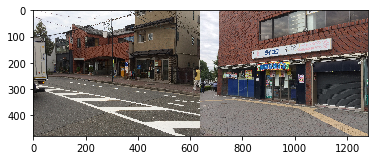

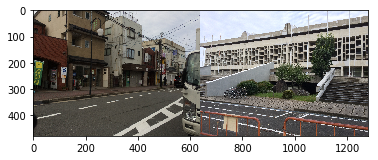

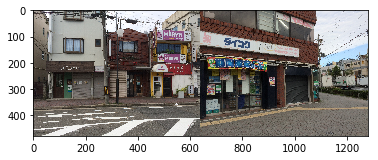

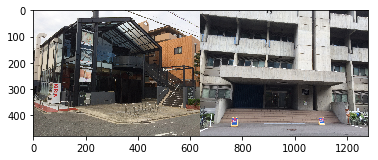

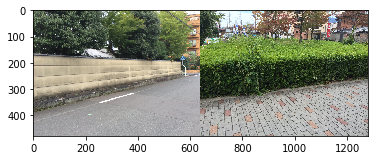

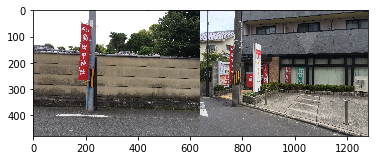

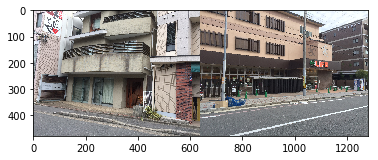

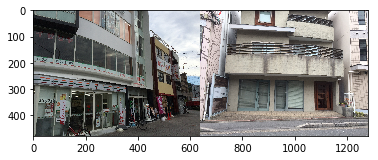

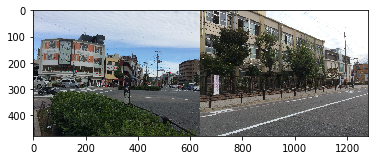

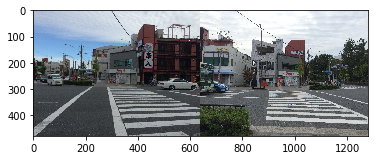

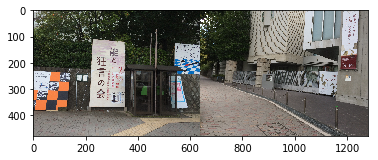

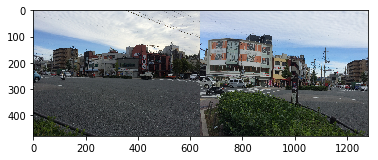

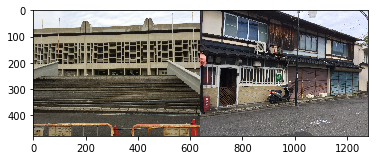

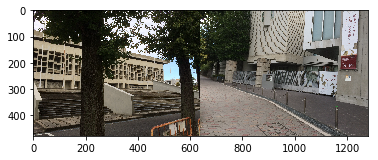

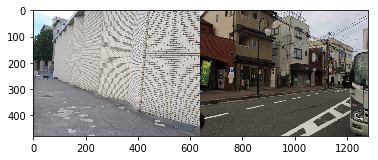

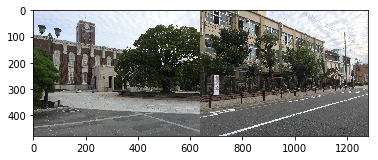

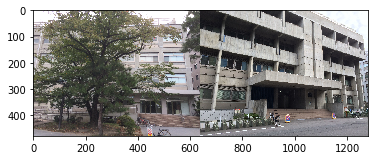

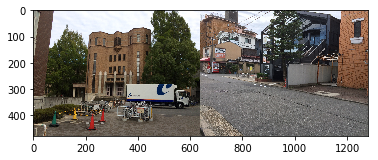

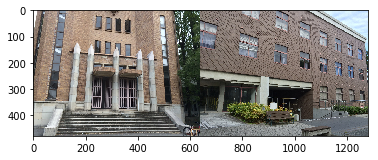

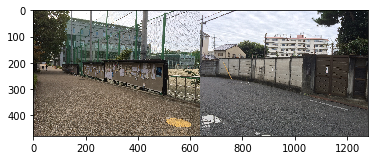

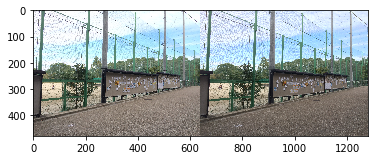

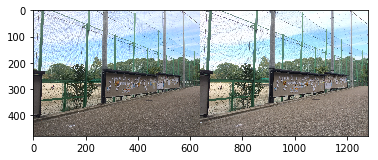

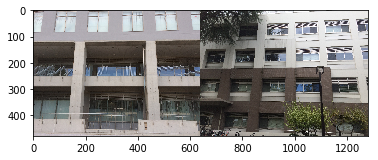

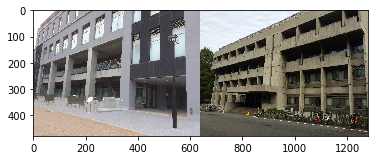

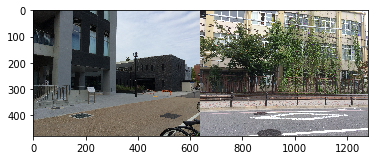

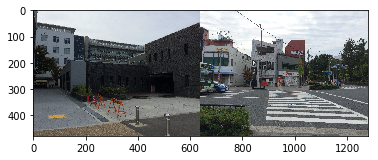

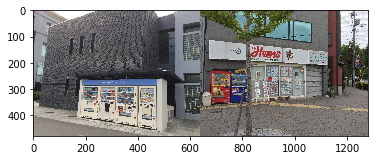

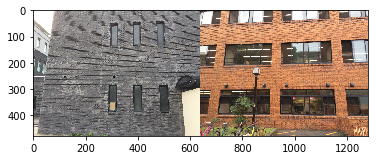

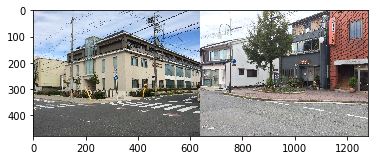

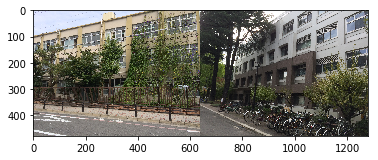

In [38]:
# show images which are incorrect
for i in range(0,pred.shape[0]):
    idx = np.argsort(val[i,:])
    idx = idx[-1::-1]    
    if gt_label[i] != gt_label[idx[1]]:
        im1 = Image.open('%s%s'%(dir,gt_name[idx[0]]),'r')
        im1 = im1.resize((640,480))
        im2 = Image.open('%s%s'%(dir,gt_name[idx[1]]),'r')
        im2 = im2.resize(im1.size)
        plt.imshow(np.hstack((np.array(im1),np.array(im2))))
        plt.show()